In [ ]:
# Importing libraries
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

In [ ]:
# Defining Image Quality Matric Functions
def psnr(target, ref):

    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])

    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))

    return scores

In [ ]:
# Preparing Images (degraded) by resizing
cwd = os.getcwd()  # Get the current working directory (cwd)
def prepare_images(path, factor):

    # loop through the files in the directory
    for file in os.listdir(path):
        try:
          # open the file
          img = cv2.imread(path + '/' + file)

          # find old and new image dimensions
          h, w, _ = img.shape
          new_height = int(h / factor)
          new_width = int(w / factor)

          # resize the image - down
          img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

          # resize the image - up
          img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)

          # save the image
          print('Saving {}'.format(file))
          cv2.imwrite('images/{}'.format(file), img)
        except:
          print('ERROR for file-', file, '!')
          pass

prepare_images('source/', 2)

Saving I004 (1).png
Saving I005 (5).png
Saving I005 (8).png
Saving I005 (6).png
Saving I005 (3).png
ERROR for file- .ipynb_checkpoints !
Saving I005 (4).png
Saving I004 (3).png
Saving I004 (2).png
Saving I005 (9).png
Saving I005 (7).png


In [ ]:
# Testing Quality difference between source and image (degraded)
for file in os.listdir('images/'):
    try:
      # open target and reference images
      target = cv2.imread('images/{}'.format(file))
      ref = cv2.imread('source/{}'.format(file))

      # calculate score
      scores = compare_images(target, ref)

      # print all three scores with new line characters (\n)
      print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))
    except:
      pass


I004 (1).png
PSNR: 30.507969753187304
MSE: 173.5420168067227
SSIM: 0.9050491751206543

I005 (5).png
PSNR: 29.27890149920032
MSE: 230.30929487179486
SSIM: 0.9341676648545291

I005 (8).png
PSNR: 32.30365007846585
MSE: 114.77217391304347
SSIM: 0.9471407577673864

I005 (6).png
PSNR: 29.70785704463235
MSE: 208.64880952380952
SSIM: 0.9431707389443926

I005 (3).png
PSNR: 33.42103470034358
MSE: 88.73565217391304
SSIM: 0.9646574602408213

I005 (4).png
PSNR: 31.75667078804424
MSE: 130.17708333333334
SSIM: 0.9358573092846395

I004 (3).png
PSNR: 29.723889074367513
MSE: 207.88
SSIM: 0.9345448564377508

I004 (2).png
PSNR: 33.66092808225389
MSE: 83.96703296703296
SSIM: 0.8992333592578778

I005 (9).png
PSNR: 33.331840520934755
MSE: 90.57692307692308
SSIM: 0.9581213205813626

I005 (7).png
PSNR: 30.7330456556994
MSE: 164.77717391304347
SSIM: 0.9552144618957236



<ipython-input-11-bc3890bc9768>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


In [ ]:
# Defining SRCNN Model

def model():
    # Define model type
    SRCNN = Sequential()

    # Adjust model layers
    SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', input_shape=(None, None, 1)))  # Changed to 'same'
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same'))
    SRCNN.add(Conv2D(filters=1, kernel_size=(5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same'))

    # Define optimizer
    adam = Adam(lr=0.0003)

    # Compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN


In [ ]:
# Defining SRCNN Model
srcnn = model()
srcnn.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, None, None, 128)   10496     
                                                                 
 conv2d_52 (Conv2D)          (None, None, None, 64)    73792     
                                                                 
 conv2d_53 (Conv2D)          (None, None, None, 1)     1601      
                                                                 
Total params: 85889 (335.50 KB)
Trainable params: 85889 (335.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Image Processing Functions
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    if image.shape[0] > 2*border and image.shape[1] > 2*border:
        img = image[border: -border, border: -border]
        return img
    else:
        return image  # or handle this case as an error


def predict(image_path):
    # Load the SRCNN model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')

    # Load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))

    # Preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)

    # Convert the image to YCrCb (SRCNN trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

    # Create image slice and normalize
    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    print(f'Before SRCNN input shape: {Y.shape}')
    pre = srcnn.predict(Y, batch_size=1)
    print(f'After SRCNN output shape: {pre.shape}')

    if temp.shape[0] == pre.shape[1] and temp.shape[1] == pre.shape[2]:
        temp[:, :, 0] = pre[0, :, :, 0].reshape(temp.shape[0], temp.shape[1])
    else:
        raise ValueError("Dimension mismatch between processed image and output from model")


    # Post-process output
    pre *= 255
    pre[pre > 255] = 255
    pre[pre < 0] = 0
    pre = pre.astype(np.uint8)

    print(f'pre shape: {pre.shape}, temp shape: {temp.shape}')
    if temp.shape[0] == pre.shape[1] and temp.shape[1] == pre.shape[2]:
        temp[:, :, 0] = pre[0, :, :, 0]
    else:
        raise ValueError(f"Dimension mismatch: processed shape {pre.shape[1:3]}, expected {temp.shape[:2]}")

    # Copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

    # Remove border from reference and degraded image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)

    # Image quality calculations
    scores = [compare_images(degraded, ref), compare_images(output, ref)]

    # Return images and scores
    return ref, degraded, output, scores





Before SRCNN input shape: (1, 12, 14, 1)
1/1 [==============================] - 0s 64ms/step


<ipython-input-11-bc3890bc9768>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


After SRCNN output shape: (1, 12, 14, 1)
pre shape: (1, 12, 14, 1), temp shape: (12, 14, 3)
Degraded Image: 
PSNR: 29.377319606182112
MSE: 225.14880952380952
SSIM: 0.8704930133030698

Reconstructed Image: 
PSNR: 27.357268775035553
MSE: 358.48809523809524
SSIM: 0.9229728164050486



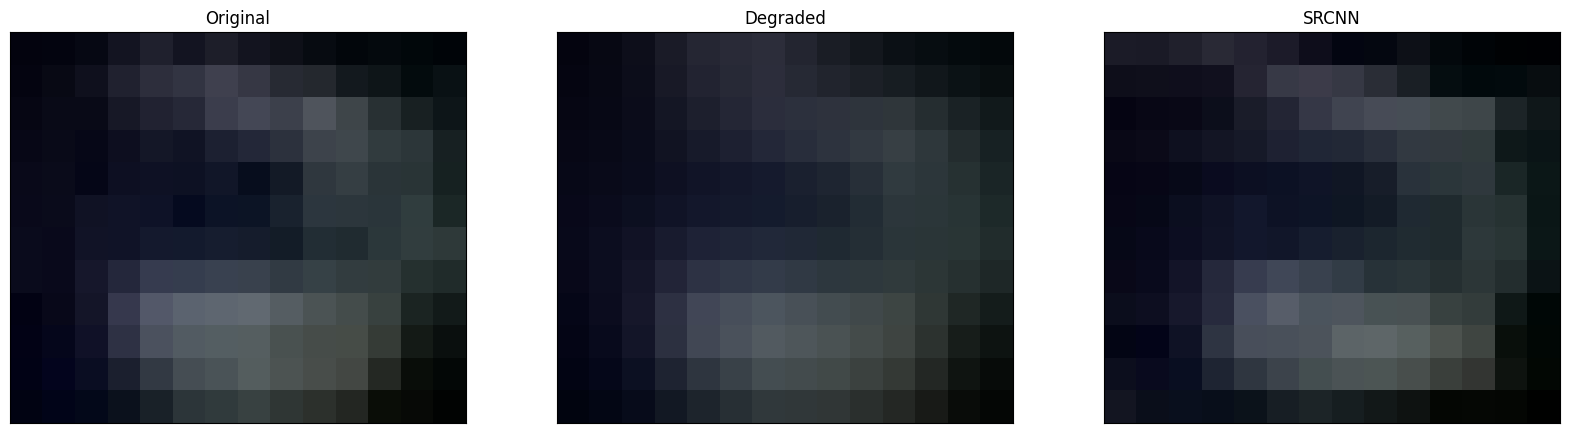

In [ ]:
ref, degraded, output, scores = predict('images/I004 (1).png')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])




Before SRCNN input shape: (1, 12, 14, 1)
1/1 [==============================] - 0s 58ms/step


<ipython-input-11-bc3890bc9768>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


After SRCNN output shape: (1, 12, 14, 1)
pre shape: (1, 12, 14, 1), temp shape: (12, 14, 3)


Saving I004 (1).png
Before SRCNN input shape: (1, 24, 23, 1)
1/1 [==============================] - 0s 64ms/step


After SRCNN output shape: (1, 24, 23, 1)
pre shape: (1, 24, 23, 1), temp shape: (24, 23, 3)
Before SRCNN input shape: (1, 21, 23, 1)
1/1 [==============================] - 0s 62ms/step
After SRCNN output shape: (1, 21, 23, 1)
pre shape: (1, 21, 23, 1), temp shape: (21, 23, 3)


Before SRCNN input shape: (1, 24, 26, 1)
1/1 [==============================] - 0s 60ms/step


After SRCNN output shape: (1, 24, 26, 1)
pre shape: (1, 24, 26, 1), temp shape: (24, 26, 3)


Before SRCNN input shape: (1, 21, 23, 1)
1/1 [==============================] - 0s 65ms/step


After SRCNN output shape: (1, 21, 23, 1)
pre shape: (1, 21, 23, 1), temp shape: (21, 23, 3)


Before SRCNN input shape: (1, 24, 23, 1)
1/1 [==============================] - 0s 61ms/step


After SRCNN output shape: (1, 24, 23, 1)
pre shape: (1, 24, 23, 1), temp shape: (24, 23, 3)
Before SRCNN input shape: (1, 15, 14, 1)
1/1 [==============================] - 0s 60ms/step
After SRCNN output shape: (1, 15, 14, 1)
pre shape: (1, 15, 14, 1), temp shape: (15, 14, 3)


Before SRCNN input shape: (1, 12, 11, 1)
1/1 [==============================] - 0s 60ms/step
After SRCNN output shape: (1, 12, 11, 1)
pre shape: (1, 12, 11, 1), temp shape: (12, 11, 3)
Saving I004 (2).png


Before SRCNN input shape: (1, 24, 23, 1)
1/1 [==============================] - 0s 58ms/step


After SRCNN output shape: (1, 24, 23, 1)
pre shape: (1, 24, 23, 1), temp shape: (24, 23, 3)
Before SRCNN input shape: (1, 24, 20, 1)
1/1 [==============================] - 0s 56ms/step
After SRCNN output shape: (1, 24, 20, 1)
pre shape: (1, 24, 20, 1), temp shape: (24, 20, 3)


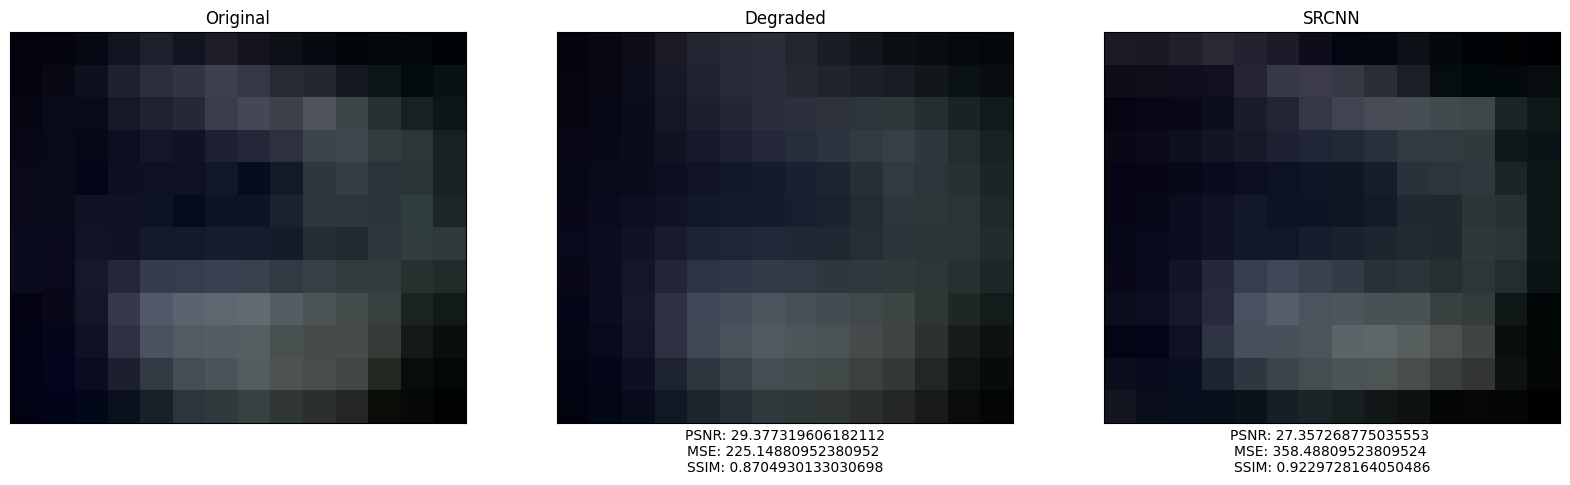

In [ ]:
# Performing Super Resolution using our SRCNN model on all images (degraded)

for file in os.listdir('images'):
    # perform super-resolution
    try:
      ref, degraded, output, scores = predict('images/{}'.format(file))
    except:
      continue


    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    print('Saving {}'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0]))
plt.close()

